In [1]:
!pip install emoji   

In [2]:
def preprocess(list_of_tweets):
  normalised_corpus =[]
  for tweet in list_of_tweets:
    words =[]
    for word in tweet:
      word = word.lower()
      word = word.strip(string.punctuation)
      word = word.strip(string.digits)
      if word not in string.punctuation and word != "user" and word !="url": 
        words.append(word)
    normalised_corpus.append(words)
  return normalised_corpus  

**preprocess training data**

In [3]:
import string #preprocess
import csv   #reading files
import emoji #to convert emojis to words using demojize function
import keras

raw_data =[] #stores all contents of tsv file as list of list [[id,tweet,A,B,C],[...]]
with open("olid-training-v1.0.tsv",encoding='UTF-8') as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        raw_data.append(row)

raw_data.remove(raw_data[0]) #remove first list item since it contains headers

#converts emoji to words and converts each tweet from string to list of words
raw_tweets = []
for tweet in raw_data:
  tweet[1] = emoji.demojize(tweet[1])
  temp = tweet[1].split()
  raw_tweets.append(temp)

 #convert to lower, remove punctuation and digits and words like 'user' and 'url' 
clean_tweets = preprocess(raw_tweets)

Using TensorFlow backend.


**getting all the labels**

In [4]:
train_labels_A = [tweet[2] for tweet in raw_data ] #label for task A

preprocessed_label_A = []   #convert label to 1 or 0 
for labelA in train_labels_A:
  if labelA =="OFF":
    preprocessed_label_A.append(1)
  else:
    preprocessed_label_A.append(0)

# print(train_labels_A)
# print(preprocessed_label_A)


In [5]:
from keras.preprocessing.text import Tokenizer

num_words=20000  #optional UNIQUE WORDS around 22156
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_tweets)

word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
sents_as_ids = tokenizer.texts_to_sequences(clean_tweets)
VOCAB_SIZE = len(word2idx)+1  # 0 saved for padding so we add 1

In [6]:
#sanity check
print(len(word2idx))  #UNIQUE WORDS around 22156
print(sents_as_ids[0])
print(' '.join(idx2word[idx] for idx in sents_as_ids[0]))

22156
[14, 77, 370, 4, 485, 2632, 291, 30, 57, 124, 17, 16, 2]
she should ask a few native americans what their take on this is


In [7]:
from keras.preprocessing.sequence import pad_sequences
MAXIMUM_LENGTH = 30 #checking
processed_train_data = pad_sequences(sents_as_ids,MAXIMUM_LENGTH,truncating='post')


**BUILDING THE MODEL**

In [83]:
EMBD_SIZE =100
model = keras.Sequential()
model.add(keras.layers.Embedding(VOCAB_SIZE,EMBD_SIZE))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.LSTM(units=100,activation='sigmoid'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, None, 100)         2215700   
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 101       
Total params: 2,296,201
Trainable params: 2,296,201
Non-trainable params: 0
_________________________________________________________________


In [84]:
partial_train_data = processed_train_data[:10240]
partial_val_data = processed_train_data[10240:]

partial_train_labels = preprocessed_label_A[:10240]
partial_val_labels = preprocessed_label_A[10240:]

history = model.fit(partial_train_data,partial_train_labels,batch_size=50,
                    epochs=4,validation_data=(partial_val_data,partial_val_labels),verbose=1)

C:\Users\Omkar\Anaconda3\envs\nlp5\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10240 samples, validate on 3000 samples
Epoch 1/4
10240/10240 [==============================] - 6s 574us/step - loss: 0.6442 - accuracy: 0.6625 - val_loss: 0.6231 - val_accuracy: 0.6683
Epoch 2/4
10240/10240 [==============================] - 5s 530us/step - loss: 0.5766 - accuracy: 0.7021 - val_loss: 0.5633 - val_accuracy: 0.7050
Epoch 3/4
10240/10240 [==============================] - 5s 535us/step - loss: 0.4016 - accuracy: 0.8218 - val_loss: 0.5573 - val_accuracy: 0.7467
Epoch 4/4
10240/10240 [==============================] - 5s 532us/step - loss: 0.2759 - accuracy: 0.8922 - val_loss: 0.6355 - val_accuracy: 0.7257


**train and validation plot**

{'val_loss': [0.6231497377157211, 0.5632989193002383, 0.5572801088293393, 0.6355028882622719], 'val_accuracy': [0.6683333516120911, 0.7049999833106995, 0.746666669845581, 0.7256666421890259], 'loss': [0.6441769044031389, 0.5766096757142805, 0.401550430979114, 0.27587776176369516], 'accuracy': [0.6625, 0.70214844, 0.82177734, 0.8921875]}


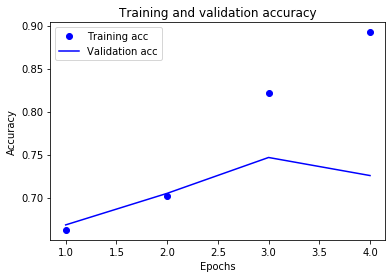

In [85]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict)
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**prerpocessing test data and labels**

In [86]:
raw_test_data =[]

with open("testset-levela.tsv",encoding='UTF-8') as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        raw_test_data.append(row)

        
raw_test_data.remove(raw_test_data[0]) #remove first element since it contains headers

#print(raw_data)

#converts emoji to words and converts each tweet from string to list of words
raw_test_tweets = []
for tweet in raw_test_data:
  tweet[1] = emoji.demojize(tweet[1])
  temp = tweet[1].split()
  raw_test_tweets.append(temp)

clean_test_tweets = preprocess(raw_test_tweets)
test_sents_as_ids = tokenizer.texts_to_sequences(clean_test_tweets)

processed_test_data = pad_sequences(test_sents_as_ids,MAXIMUM_LENGTH,truncating='post')

print(clean_test_tweets[9])
print(processed_test_data[9])


['biggbosstamil', 'janani', 'won', 'the', 'task', 'she', 'is', 'going', 'to', 'first', 'final', 'list:clapping_hands::clapping_hands::clapping_hands::clapping_hands']
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0 16817  1403     1  5529
    14     2    91     3   198  2025]


In [87]:
def get_test_labels(path):
  raw_test_labels =[]
  with open(path) as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        raw_test_labels.append(row)
  temp_test_labels = [labels[0].split(',') for labels in raw_test_labels]
  return temp_test_labels

#get labels with IDs
raw_test_labels_A = get_test_labels('labels-levela.csv')

processed_test_labels_A = []
for label in raw_test_labels_A:
    if label[1] =="OFF":
        processed_test_labels_A.append(1)
    else:
        processed_test_labels_A.append(0)
    

In [88]:
#evaluate the model
result = model.evaluate(processed_test_data,processed_test_labels_A,batch_size=128)
print(result)

860/860 [==============================] - 0s 56us/step
[0.5760680054509363, 0.7848837375640869]
